In [1]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

lottery_dataframe = pd.read_csv("lottery.csv", sep=",")
lottery_dataframe = lottery_dataframe.reindex(np.random.permutation(lottery_dataframe.index))

In [2]:
def preprocess_features(lottery_dataframe):
  selected_features = lottery_dataframe[
    ["day",
     "month",
     "year",
     #"no1",
     #"top2",
     #"top3",
     #"front3_1",
     #"front3_2",
     #"bottom3_1",     
     #"bottom3_2"
    ]]
  return selected_features

def preprocess_targets(lottery_dataframe):
  output_targets = pd.DataFrame()
  output_targets["bottom2"] = lottery_dataframe["bottom2"]
  return output_targets

In [3]:
# Choose the first 578 (out of 684) examples for training.
training_examples = preprocess_features(lottery_dataframe.head(580))
training_targets = preprocess_targets(lottery_dataframe.head(580))

# Choose the last 106 (out of 684) examples for validation.
validation_examples = preprocess_features(lottery_dataframe.tail(100))
validation_targets = preprocess_targets(lottery_dataframe.tail(100))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,day,month,year
count,580.0,580.0,580.0
mean,9.7,6.9,2003.8
std,8.3,3.5,8.2
min,1.0,1.0,1990.0
25%,1.0,4.0,1997.0
50%,16.0,7.0,2004.0
75%,16.0,10.0,2011.0
max,30.0,12.0,2018.0


Validation examples summary:


,day,month,year
count,100.0,100.0,100.0
mean,10.3,6.7,2003.5
std,8.8,3.2,8.5
min,1.0,1.0,1990.0
25%,1.0,4.0,1996.0
50%,16.0,6.0,2001.5
75%,16.0,9.0,2011.2
max,30.0,12.0,2018.0


Training targets summary:


,bottom2
count,580.0
mean,51.3
std,28.8
min,0.0
25%,26.8
50%,53.0
75%,76.0
max,99.0


Validation targets summary:


,bottom2
count,100.0
mean,53.5
std,30.2
min,1.0
25%,25.2
50%,52.5
75%,85.0
max,99.0


In [4]:
def construct_feature_columns(input_features):
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [5]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural network model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [6]:
def train_nn_regression_model(
    my_optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    my_optimizer: An instance of `tf.train.Optimizer`, the optimizer to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `dataframecalifornia_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `dataframecalifornia_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `dataframecalifornia_housing_dataframe` to use as target for validation.
      
  Returns:
    A tuple `(estimator, training_losses, validation_losses)`:
      estimator: the trained `DNNRegressor` object.
      training_losses: a `list` containing the training loss values taken during training.
      validation_losses: a `list` containing the validation loss values taken during training.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["bottom2"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["bottom2"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["bottom2"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor, validation_predictions #, training_rmse, validation_rmse

Training model...
RMSE (on training data):
  period 00 : 31.12
  period 01 : 28.97
  period 02 : 28.92
  period 03 : 28.99
  period 04 : 34.10
  period 05 : 28.96
  period 06 : 28.77
  period 07 : 28.78
  period 08 : 28.78
  period 09 : 28.77
Model training finished.
Final RMSE (on training data):   28.77
Final RMSE (on validation data): 30.08


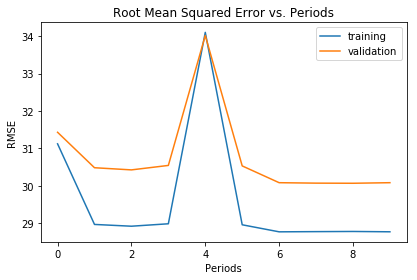

In [7]:
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001) # 28.74, 29.74
#my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.001)        # 28.86, 29.84
#my_optimizer = tf.train.AdamOptimizer(learning_rate=0.001)           # 29.03, 30.03

r, p = train_nn_regression_model(
            my_optimizer=my_optimizer,
            steps=5000,
            batch_size=10,
            hidden_units=[100, 50],
            training_examples=training_examples,
            training_targets=training_targets,
            validation_examples=validation_examples,
            validation_targets=validation_targets)

,bottom2,predict
122,90,52.5
138,58,52.5
581,21,51.6
572,67,52.0
104,35,52.6
...,...,...
240,50,52.4
147,31,52.0
526,61,52.1
204,87,51.5


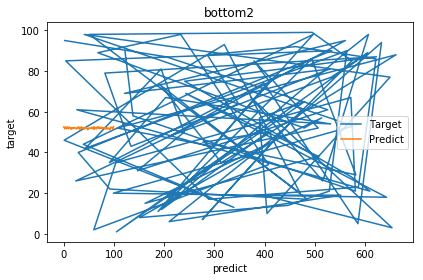

In [39]:
my_target = validation_targets.copy()
my_target['predict'] = p
my_target

# Output a graph of loss metrics over periods.
plt.ylabel("target")
plt.xlabel("predict")
plt.title("bottom2")
plt.tight_layout()
plt.plot(validation_targets, label="Target")
plt.plot(p, label="Predict")
plt.legend()

my_target